In [1]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")

Detected Linux: defaulting to Torch backend
Final Keras backend: Torch


In [2]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()


GPU available: Tesla T4
Using GPU


## Preprocessing Data with Cyclical encoding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Import dataset of df_hour.csv, the datetime column was the index
import pandas as pd
data = pd.read_csv('df_hour.csv', index_col = 'datetime', parse_dates=['datetime'])

In [5]:
# Check the datatype of the index
print(data.index.dtype)

datetime64[ns]


#### Adding Cyclical encodings
- Adding sine/cosine of hours.

In [6]:
updated_features = data.copy()

updated_features['hour'] = updated_features.index.hour

updated_features['hour_sin'] = np.sin(2 * np.pi * updated_features['hour'] / 24)
updated_features['hour_cos'] = np.cos(2 * np.pi * updated_features['hour'] / 24)

In [7]:
corr = updated_features.corr()['Global_active_power'].sort_values(ascending=False)
print(corr)

Global_active_power      1.000000
Global_intensity         0.999414
Sub_metering_3           0.696571
Sub_metering_1           0.496978
Sub_metering_2           0.440434
hour                     0.329218
Global_reactive_power    0.309512
hour_cos                -0.128267
hour_sin                -0.220287
Voltage                 -0.374507
Name: Global_active_power, dtype: float64


In [8]:
#Splitting the data into train, validation, and test sets (70%, 15%, 15%)
# Get the number of samples
n = len(updated_features)

# Compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n)  # 70% + 15%

# Split without shuffling (important for time series!)
train = updated_features.iloc[:train_end]
val = updated_features.iloc[train_end:val_end]
test = updated_features.iloc[val_end:]

print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")
train.head()

Train shape: (24212, 10), Validation shape: (5188, 10), Test shape: (5189, 10)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,hour_sin,hour_cos
datetime,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,-0.965926,-2.588190e-01
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,-1.000000,-1.836970e-16
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,-0.965926,2.588190e-01
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,-0.866025,5.000000e-01
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,-0.707107,7.071068e-01


In [9]:
# Scaling data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()


#Define X_cols:
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity',
          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','hour', 'hour_sin', 'hour_cos']

train_scaled = train.copy()
train_scaled = scaler_X.fit_transform(train[X_cols])
y_train = scaler_Y.fit_transform(train[['Global_active_power']])

#Recreate dataframe with the datetime column as index
train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=X_cols)


val_scaled = val.copy()

#Scaling the validation and test sets
val_scaled = scaler_X.transform(val[X_cols])
val_y = scaler_Y.transform(val[['Global_active_power']])

#Recreate dataframe with the datetime column as index
val_scaled = pd.DataFrame(val_scaled, index=val.index, columns=X_cols)

test_scaled = test.copy()

test_scaled = scaler_X.transform(test[X_cols])
test_y = scaler_Y.transform(test[['Global_active_power']])

#Recreate dataframe with the datetime column as index
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=X_cols)

In [10]:
print(f"Train scaled shape: {train_scaled.shape}, Validation scaled shape: {val_scaled.shape}, Test scaled shape: {test_scaled.shape}")

Train scaled shape: (24212, 9), Validation scaled shape: (5188, 9), Test scaled shape: (5189, 9)


In [11]:
#Create sliding windows that has a look back of 24hours and predicts 1 hour ahead. This will then allow us to get predictions for every hour
def create_sliding_windows(X, y, look_back=24, forecast_horizon=1):
    X_windows, y_windows = [], []
    for i in range(len(X) - look_back - forecast_horizon + 1):
        X_windows.append(X.iloc[i:i + look_back].values)
        y_windows.append(y[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)

X_train, y_train_windows = create_sliding_windows(train_scaled, y_train)
X_val, y_val_windows = create_sliding_windows(val_scaled, val_y)
X_test, y_test_windows = create_sliding_windows(test_scaled, test_y)

# Model tests with LSTM

#### Model Change 1
- Adding cyclycal enconding.

In [1]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

look_back = 24

# build the LSTM model with 50 units , dense output layer with 1 unit for regression
model = Sequential()
model.add(Input(shape=(look_back, X_train.shape[2]))) # Explicit Input layer
model.add(LSTM(100, activation='relu')) # Add return_sequences=True here)
model.add(Dense(1))


# compile the model
model.compile(optimizer = "adam", loss = "mse")


# display the model summary
model.summary()

NameError: name 'X_train' is not defined

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch = 5,
                           restore_best_weights=True)



# Train the LSTM model with early stopping
history = model.fit(X_train, y_train_windows,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (X_val, y_val_windows),
                    shuffle = False,
                    callbacks = [early_stop],
                    verbose = 1)

Epoch 1/20
169/756 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.0878

KeyboardInterrupt: 

756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Train RMSE: 0.545
Val   RMSE: 0.545
Test  RMSE: 0.461


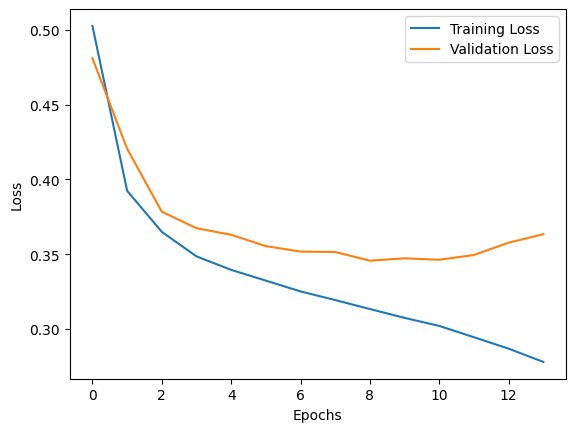

In [ ]:
#Obtain predictions and get the test rmse
#Import root_mean_squared_error and mean_absolute_error from sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# Making prediction for each datasets: train, validation, test
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Inverse transform predictions to the original units
train_pred_inv = scaler_Y.inverse_transform(train_pred)
test_pred_inv = scaler_Y.inverse_transform(test_pred)
val_pred_inv = scaler_Y.inverse_transform(val_pred)

# Inverse transform actual target values to the original units
train_y_inv  = scaler_Y.inverse_transform(y_train_windows)
val_y_inv = scaler_Y.inverse_transform(y_val_windows)
test_y_inv = scaler_Y.inverse_transform(y_test_windows)

# Evaluate the model performance
train_rmse = root_mean_squared_error(train_y_inv, train_pred_inv)
test_rmse = root_mean_squared_error(test_y_inv, test_pred_inv)
val_rmse = root_mean_squared_error(val_y_inv, val_pred_inv)

# Print RMSE and MAE for each split
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Val   RMSE: {val_rmse:.3f}")
print(f"Test  RMSE: {test_rmse:.3f}")

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

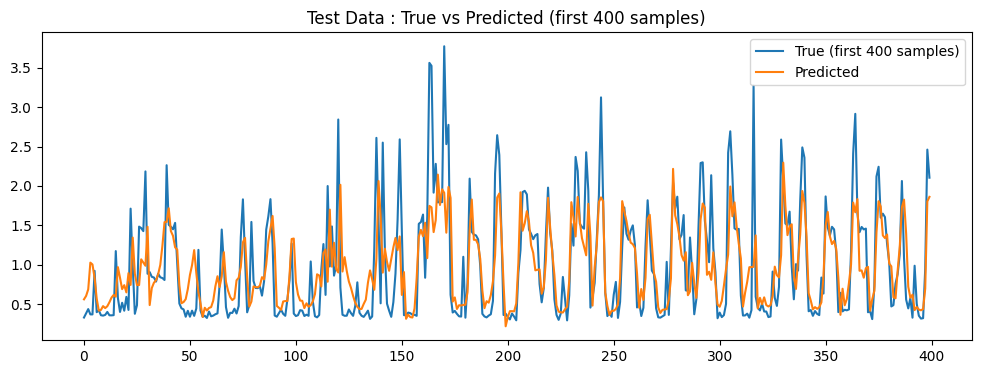

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_y_inv[:400], label='True (first 400 samples)')
plt.plot(test_pred_inv[:400], label='Predicted')
plt.legend();
plt.title('Test Data : True vs Predicted (first 400 samples)');
plt.show()

Conclusion: The cyclic encoding helps with the model. It worked way better than not using any time series columns. The test RMSE decreased from 0.551 to 0.461. The train and validation data were roughly the same performance. But a decrease in 0.09 is huge in my opinion.

#### Model Change
- adding Dropout of 0.3
- adding learning rate of 0.001 in Adam Optimizer

In [ ]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout # Import Dropout layer
from keras.optimizers import Adam # Import Adam optimizer

look_back = 24

# build the LSTM model with 50 units , dense output layer with 1 unit for regression
model2 = Sequential()
model2.add(Input(shape=(look_back, X_train.shape[2]))) # Explicit Input layer
model2.add(LSTM(100, activation='relu')) #Add a dropout layer
model2.add(Dropout(0.3)) # Correctly add the Dropout layer

model2.add(Dense(1))


# compile the model
model2.compile(optimizer = Adam(learning_rate = 0.001), loss = "mse")


# display the model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch = 5,
                           restore_best_weights=True)



# Train the LSTM model with early stopping
history = model2.fit(X_train, y_train_windows,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (X_val, y_val_windows),
                    shuffle = False,
                    callbacks = [early_stop],
                    verbose = 1)

Epoch 1/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 0.7666 - val_loss: 0.5303
Epoch 2/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.5178 - val_loss: 0.4642
Epoch 3/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.4690 - val_loss: 0.4120
Epoch 4/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.4429 - val_loss: 0.3977
Epoch 5/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.4255 - val_loss: 0.3799
Epoch 6/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.4143 - val_loss: 0.3715
Epoch 7/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.4012 - val_loss: 0.3786
Epoch 8/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.3964 - val_loss: 0.3733
Epoch 9/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.3928 - val_loss: 0.3796
Epoch 10/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.3878 - val_loss: 0.3752
Epoch 11/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.3835 - val_loss: 0.3636
Epoch 12/20
756/756 ━━━━━━━━━━

756/756 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Train RMSE Model 2: 0.506
Val   RMSE Model 2: 0.547
Test  RMSE Model 2: 0.458


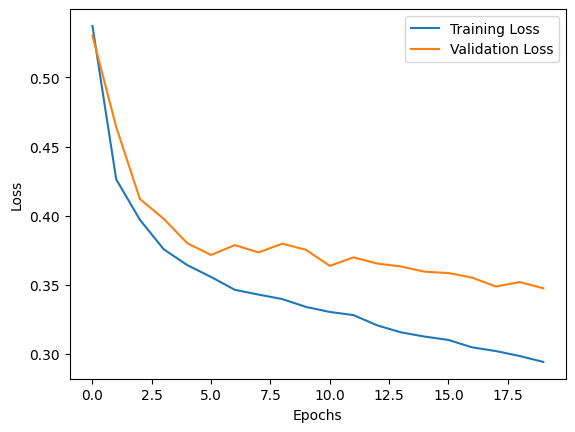

In [ ]:
#Obtain predictions and get the test rmse
#Import root_mean_squared_error and mean_absolute_error from sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


# Making prediction for each datasets: train, validation, test
train_pred2 = model2.predict(X_train)
val_pred2 = model2.predict(X_val)
test_pred2 = model2.predict(X_test)

#Inverse transform predictions to the original units
train_pred_inv2 = scaler_Y.inverse_transform(train_pred2)
test_pred_inv2 = scaler_Y.inverse_transform(test_pred2)
val_pred_inv2 = scaler_Y.inverse_transform(val_pred2)

# Inverse transform actual target values to the original units
train_y_inv2  = scaler_Y.inverse_transform(y_train_windows)
val_y_inv2 = scaler_Y.inverse_transform(y_val_windows)
test_y_inv2 = scaler_Y.inverse_transform(y_test_windows)

# Evaluate the model performance
train_rmse = root_mean_squared_error(train_y_inv2, train_pred_inv2)


test_rmse = root_mean_squared_error(test_y_inv2, test_pred_inv2)


val_rmse = root_mean_squared_error(val_y_inv2, val_pred_inv2)



# Print RMSE and MAE for each split
print(f"Train RMSE Model 2: {train_rmse:.3f}")
print(f"Val   RMSE Model 2: {val_rmse:.3f}")
print(f"Test  RMSE Model 2: {test_rmse:.3f}")

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

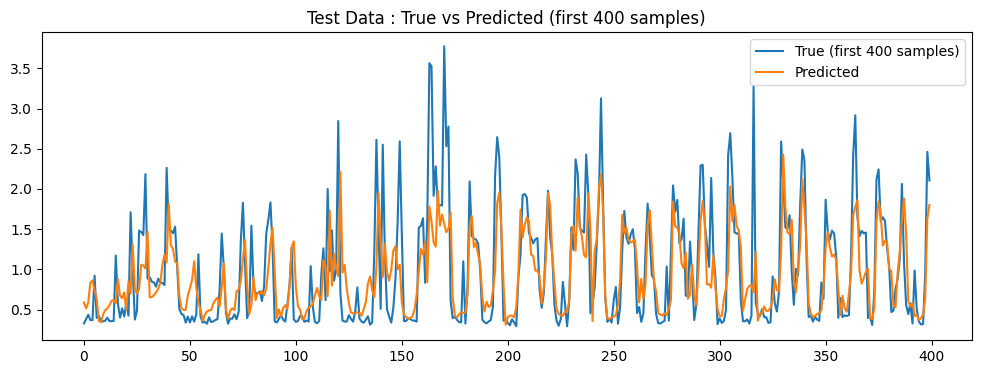

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_y_inv2[:400], label='True (first 400 samples)')
plt.plot(test_pred_inv2[:400], label='Predicted')
plt.legend();
plt.title('Test Data : True vs Predicted (first 400 samples)');
plt.show()

After running the LSTM model with dropout of 0.3 and learning rate of 0.001 we inreased the performance of the model. We observed a test RMSE of 0.458 which is .461. Even better then validation and training RMSE improved signficantly. Now we want to add more layers and see if it can help with performance.   

#### Model Changes
- Added another LSTM layer
- added droput of 0.2 and 0.1

In [ ]:
# build the LSTM model with 50 units , dense output layer with 1 unit for regression
model3 = Sequential()
model3.add(Input(shape=(look_back, X_train.shape[2]))) # Explicit Input layer
model3.add(LSTM(100, activation='relu', return_sequences = True)) #Add a dropout layer
model3.add(Dropout(0.2)) # Correctly add the Dropout layer
model3.add(LSTM(50, activation='relu')) #Adding two LSTM layers
model3.add(Dropout(0.1))

model3.add(Dense(1))


# compile the model
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = "mse")


# display the model summary
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,251 (290.04 KB)

 Trainable params: 74,251 (290.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model with early stopping
history3 = model3.fit(X_train, y_train_windows,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (X_val, y_val_windows),
                    shuffle = False,
                    callbacks = [early_stop],
                    verbose = 1)

Epoch 1/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - loss: 0.8556 - val_loss: 0.5393
Epoch 2/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 0.5321 - val_loss: 0.4626
Epoch 3/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 0.4675 - val_loss: 0.4143
Epoch 4/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - loss: 0.4423 - val_loss: 0.3906
Epoch 5/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 0.4203 - val_loss: 0.3804
Epoch 6/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 0.4113 - val_loss: 0.3886
Epoch 7/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - loss: 0.4058 - val_loss: 0.3886
Epoch 8/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 72ms/step - loss: 0.4011 - val_loss: 0.3845
Epoch 9/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 72ms/step - loss: 0.3896 - val_loss: 0.3853
Epoch 10/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - loss: 0.3895 - val_loss: 0.3674
Epoch 11/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 0.3777 - val_loss: 0.3638
Epoch 12/20
756/756 ━━━━━━━━━━

756/756 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Train RMSE Model 2: 0.526
Val   RMSE Model 2: 0.557
Test  RMSE Model 2: 0.462


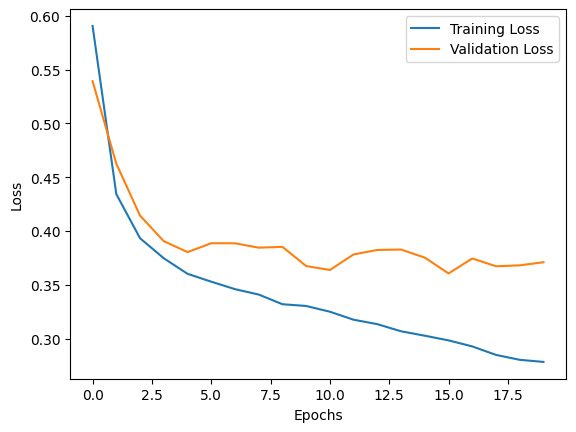

In [ ]:
#Obtain predictions and get the test rmse
#Import root_mean_squared_error and mean_absolute_error from sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# Making prediction for each datasets: train, validation, test
train_pred3 = model3.predict(X_train)
val_pred3 = model3.predict(X_val)
test_pred3 = model3.predict(X_test)

#Inverse transform predictions to the original units
train_pred_inv3= scaler_Y.inverse_transform(train_pred3)
test_pred_inv3 = scaler_Y.inverse_transform(test_pred3)
val_pred_inv3 = scaler_Y.inverse_transform(val_pred3)

# Inverse transform actual target values to the original units
train_y_inv3  = scaler_Y.inverse_transform(y_train_windows)
val_y_inv3 = scaler_Y.inverse_transform(y_val_windows)
test_y_inv3 = scaler_Y.inverse_transform(y_test_windows)

# Evaluate the model performance
train_rmse3 = root_mean_squared_error(train_y_inv3, train_pred_inv3)
test_rmse3 = root_mean_squared_error(test_y_inv3, test_pred_inv3)
val_rmse3 = root_mean_squared_error(val_y_inv3, val_pred_inv3)

# Print RMSE and MAE for each split
print(f"Train RMSE Model 2: {train_rmse3:.3f}")
print(f"Val   RMSE Model 2: {val_rmse3:.3f}")
print(f"Test  RMSE Model 2: {test_rmse3:.3f}")

# plot the training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After doing two iterations of two layers of LSTM layers I can conclude with confidence that two of them is less optimal than having 1 LSTM layer. It had similar and even better performance. Now we need to change the orignal one layer LSTM model to get better results.

#### Model Changes

In [ ]:
# build the LSTM model with 50 units , dense output layer with 1 unit for regression
model4 = Sequential()
model4.add(Input(shape=(look_back, X_train.shape[2]))) # Explicit Input layer
model4.add(LSTM(100, activation='tanh')) #Add a dropout layer
model4.add(Dropout(0.2)) # Correctly add the Dropout layer

model4.add(Dense(1))


# compile the model
model4.compile(optimizer = Adam(learning_rate = 0.001), loss = "mse")


# display the model summary
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100)            │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model with early stopping
from keras.callbacks import ReduceLROnPlateau


learning_rate = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
history4 = model4.fit(X_train, y_train_windows,
                    epochs = 80,
                    batch_size = 32,
                    validation_data = (X_val, y_val_windows),
                    shuffle = False,
                    callbacks = [early_stop,learning_rate],
                    verbose = 1)

Epoch 1/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.7210 - val_loss: 0.4838 - learning_rate: 0.0010
Epoch 2/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.4769 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 3/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.4325 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 4/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.4131 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 5/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.4008 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 6/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.3983 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 7/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.3909 - val_loss: 0.3671 - learning_rate: 0.0010
Epoch 8/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.3800 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 9/80
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.3774 - val_loss: 0.3615 - learning_rate:

756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Train RMSE Model 2: 0.474
Val   RMSE Model 2: 0.543
Test  RMSE Model 2: 0.463


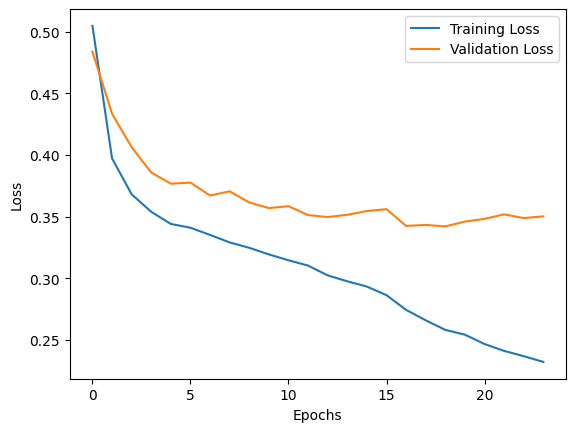

In [ ]:
#Obtain predictions and get the test rmse

# Making prediction for each datasets: train, validation, test
train_pred4 = model4.predict(X_train)
val_pred4 = model4.predict(X_val)
test_pred4 = model4.predict(X_test)

#Inverse transform predictions to the original units
train_pred_inv4= scaler_Y.inverse_transform(train_pred4)
test_pred_inv4 = scaler_Y.inverse_transform(test_pred4)
val_pred_inv4 = scaler_Y.inverse_transform(val_pred4)

# Inverse transform actual target values to the original units
train_y_inv4  = scaler_Y.inverse_transform(y_train_windows)
val_y_inv4 = scaler_Y.inverse_transform(y_val_windows)
test_y_inv4 = scaler_Y.inverse_transform(y_test_windows)

# Evaluate the model performance
train_rmse4 = root_mean_squared_error(train_y_inv4, train_pred_inv4)
test_rmse4 = root_mean_squared_error(test_y_inv4, test_pred_inv4)
val_rmse4 = root_mean_squared_error(val_y_inv3, val_pred_inv4)

# Print RMSE and MAE for each split
print(f"Train RMSE Model 2: {train_rmse4:.3f}")
print(f"Val   RMSE Model 2: {val_rmse4:.3f}")
print(f"Test  RMSE Model 2: {test_rmse4:.3f}")

# plot the training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The train loss decreased signficantly, however the test RMSE did not decrease it slightly increaed. Thus model 2 is the best model.

  - Settings of the Best Model:
    - LSTM layer of 100
    - Dropout layer of 0.3
    - learning rate = 0.001
    - 20 Epochs
    - Batch_Size = 32
    - Early Stopping (patience = 5, start_from = 5)

  - Results of the Best Model:
    - Train RMSE: 0.506
    - Validation RMSE: 0.547
    - Test RMSE: 0.458